<a href="https://colab.research.google.com/github/ioloi1128/CDA/blob/main/CDA_week3_composite.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install

In [ ]:
!pip install numpy
!pip install xarray
!pip install matplotlib
!pip install scipy

Define

In [ ]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import scipy as stats
from scipy.stats import ttest_ind_from_stats

Load data

In [ ]:
url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
ds = xr.open_dataset(url)
#print(ds)
#ds

# select period
ds = ds.sel(time=slice('1960', '2020'))
ds

#actually load the data
ds.load()

NameError: ignored

Process data

In [ ]:
#make anomaly
sst_clim = ds.sst.groupby('time.month').mean(dim='time')
sst_anom = ds.sst.groupby('time.month') - sst_clim

In [ ]:
#detrend
from scipy.signal import detrend
sst_anom_detrended = xr.apply_ufunc(detrend, sst_anom.fillna(0),
                                    kwargs={'axis': 0}).where(~sst_anom.isnull())

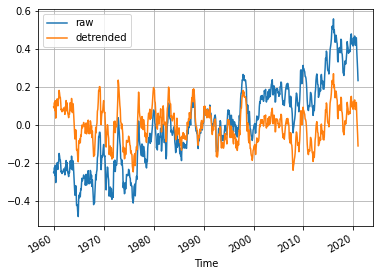

In [ ]:
# For a global average, we need to weigh the points by cosine of latitude.
# This is not built into xarray because xarray is not specific to geoscientific data.
weights = np.cos(np.deg2rad(ds.lat)).where(~sst_anom[0].isnull())
weights /= weights.mean()

(sst_anom * weights).mean(dim=['lon', 'lat']).plot(label='raw')
(sst_anom_detrended * weights).mean(dim=['lon', 'lat']).plot(label='detrended')
plt.grid()
plt.legend()

In [ ]:
sst_anom_nino34 = sst_anom_detrended.sel(lat=slice(5, -5), lon=slice(190, 240))
sst_anom_nino34_mean = sst_anom_nino34.mean(dim=('lon', 'lat'))
oni = sst_anom_nino34_mean.rolling(time=3, center=True).mean()

In [ ]:
oni.to_netcdf(path="/content/drive/My Drive/Colab_data/ENSOindex.oni.1960-2020.nc")

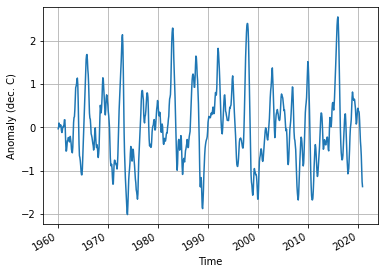

In [ ]:
oni.plot()
plt.grid()
plt.ylabel('Anomaly (dec. C)');

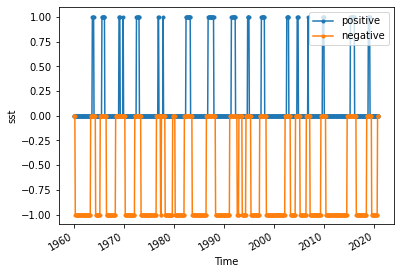

In [ ]:
positive_oni = ((oni>0.5).astype('b').rolling(time=5, center=True).sum()==5)
negative_oni = ((oni<0.5).astype('b').rolling(time=5, center=True).sum()==5)
positive_oni.astype('i').plot(marker='.', label='positive')
(-negative_oni.astype('i')).plot(marker='.', label='negative')
plt.legend()

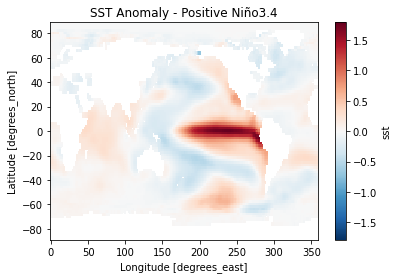

In [ ]:
sst_anom.where(positive_oni).mean(dim='time').plot()
plt.title('SST Anomaly - Positive Niño3.4');

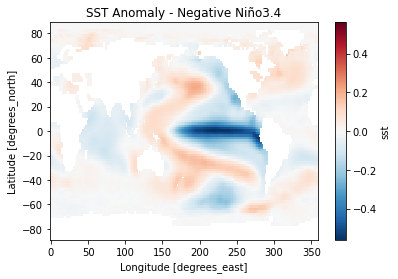

In [ ]:
sst_anom.where(negative_oni).mean(dim='time').plot()
plt.title('SST Anomaly - Negative Niño3.4');

Add sifnificant ttest

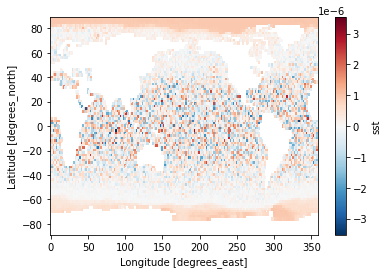

In [ ]:
mean1 = sst_anom.where(positive_oni).mean(dim='time')
mean2 = sst_anom.mean(dim='time')

#mean1.plot()
mean2.plot()

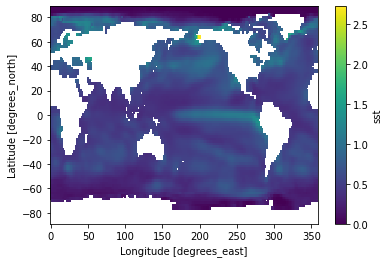

In [ ]:
std1 = sst_anom.where(positive_oni).std(dim='time')
#std1.plot()
std2 = sst_anom.std(dim='time')
std2.plot()

In [ ]:
nobs1 = np.count_nonzero(positive_oni)
print(nobs1)
nobs2 = len(oni)
nobs2

99


732

In [ ]:
modified_std1 = np.sqrt(np.float32(nobs1)/np.float32(nobs1-1)) * std1
#modified_std1
modified_std2 = np.sqrt(np.float32(nobs2)/np.float32(nobs2-1)) * std2
#modified_std2

In [ ]:
import scipy.stats as stats
from scipy.stats import ttest_ind, ttest_ind_from_stats

In [ ]:
(statistic, pvalue) = stats.ttest_ind_from_stats(mean1=mean1, std1=modified_std1, nobs1=nobs1, mean2=mean2, std2=modified_std2, nobs2=nobs2 )
print(pvalue)

[[0.38909961 0.41306036 0.43106631 ... 0.36713433 0.36882021 0.37061228]
 [0.42131554 0.43384157 0.4464511  ... 0.44645313 0.43058314 0.41881147]
 [0.59077489 0.44644644 0.44644687 ... 0.58828531 0.59076276 0.59076448]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]]


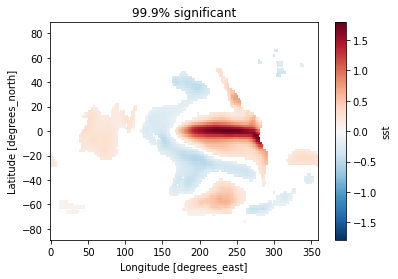

In [ ]:
alpha=0.001
mean1_sig=mean1.where(pvalue <= alpha)
mean1_sig.plot()
plt.title('99.9% significant');

In [ ]:
mean1_sig.to_netcdf(path="/content/drive/My Drive/Colab_data/Elnino_sig.nc")
mean1.to_netcdf(path="/content/drive/My Drive/Colab_data/Elnino_nosig.nc")